In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel(r'D:\MSc Software and AI\Team Project\TurbineTeamProject\data\dundalk.xlsx')

In [3]:
df.set_index(['Timestamps'], inplace= True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 653103 entries, 2006-01-30 20:30:00 to 2020-03-12 12:20:00
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WindSpeed        653103 non-null  float64
 1   StdDevWindSpeed  653103 non-null  float64
 2   WindDirAbs       653103 non-null  float64
 3   WindDirRel       653103 non-null  float64
 4   Power            653103 non-null  float64
 5   MaxPower         653103 non-null  float64
 6   MinPower         653103 non-null  float64
 7   StdDevPower      653103 non-null  float64
 8   AvgRPow          653103 non-null  float64
 9   Pitch            653103 non-null  float64
 10  GenRPM           653103 non-null  int64  
 11  RotorRPM         653103 non-null  float64
 12  EnvirTemp        653103 non-null  int64  
 13  NacelTemp        653103 non-null  int64  
 14  GearOilTemp      653103 non-null  int64  
 15  GearBearTemp     653103 non-null  int64  
 16  GenT

In [5]:
high_corr_features = ['WindSpeed',
 'GenPh1Temp',
 'GenPh2Temp',
 'GenPh3Temp',
 'Power']

In [6]:
df_corr = df[high_corr_features]

In [7]:
features = ['WindSpeed',
 'GenPh1Temp',
 'GenPh2Temp',
 'GenPh3Temp',]
target = 'Power'

In [8]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [9]:

df[features] = scaler_X.fit_transform(df[features])
df[[target]] = scaler_y.fit_transform(df[[target]])

In [10]:
train_data = df_corr.loc[:'2018-09-10'] #04-10-2018
test_data = df_corr.loc['2018-09-11':'2018-10-02']

In [11]:
test_data

,WindSpeed,GenPh1Temp,GenPh2Temp,GenPh3Temp,Power
Timestamps,,,,,
2018-09-11 00:00:00,8.2,58,67,57,313.8
2018-09-11 00:10:00,7.5,56,65,55,241.4
2018-09-11 00:20:00,7.2,54,63,53,198.1
2018-09-11 00:30:00,5.3,52,62,52,73.2
2018-09-11 00:40:00,7.4,53,63,53,209.7
...,...,...,...,...,...
2018-10-02 23:10:00,7.5,52,62,52,213.6
2018-10-02 23:20:00,7.7,53,64,53,234.5
2018-10-02 23:30:00,8.1,56,66,56,287.5


In [12]:
train_X, train_y = train_data[features].values, train_data[[target]].values
test_X, test_y = test_data[features].values, test_data[[target]].values

In [13]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., using last 10 timestamps)
seq_length = 2

# Create sequences
X_train_seq, y_train_seq = create_sequences(train_X, train_y, seq_length)
X_test_seq, y_test_seq = create_sequences(test_X, test_y, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)


In [14]:
class WindPowerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WindPowerLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Instantiate model
input_size = 4  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

model = WindPowerLSTM(input_size, hidden_size, num_layers, output_size)


In [15]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 2  == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [2/20], Loss: 171303699.7191
Epoch [4/20], Loss: 165795008.9860
Epoch [6/20], Loss: 163560524.1404
Epoch [8/20], Loss: 162827203.3058
Epoch [10/20], Loss: 161606288.8668
Epoch [12/20], Loss: 160404324.1123
Epoch [14/20], Loss: 159502595.5919
Epoch [16/20], Loss: 159883319.0511
Epoch [18/20], Loss: 158616653.2486
Epoch [20/20], Loss: 157708176.3374


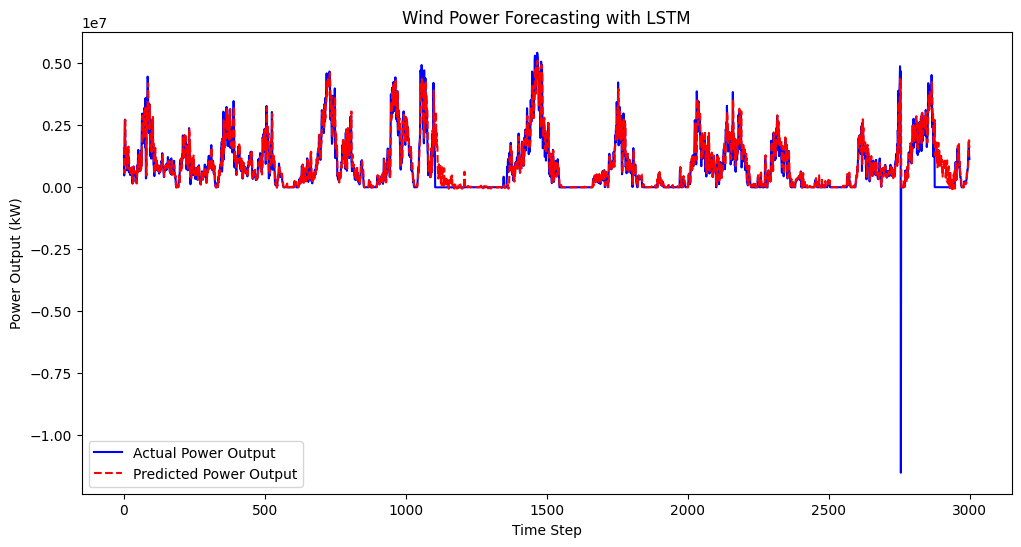

In [16]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convert predictions to numpy arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Reverse scaling for interpretability
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Plot predictions vs actuals
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Actual Power Output", color="blue")
plt.plot(predictions, label="Predicted Power Output", color="red", linestyle="dashed")
plt.xlabel("Time Step")
plt.ylabel("Power Output (kW)")
plt.title("Wind Power Forecasting with LSTM")
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure predictions and actuals are properly shaped
predictions = predictions.flatten()
actuals = actuals.flatten()

# actuals = actuals[actuals > 0]  # Avoid division by zero in MAPE
# predictions = predictions[:len(actuals)]  # Match lengths
# Compute metrics
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)  # RMSE = sqrt(MSE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100  # Mean Absolute Percentage Error

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 1051203.7500
Root Mean Squared Error (RMSE): 1416078.6250
Mean Absolute Percentage Error (MAPE): 418.14%


c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
actuals

array([1269319.5,  466961.9, 1343837.9, ..., 1843625.1, 1300797.1,
       1125421.9], dtype=float32)